In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from importlib import reload
from time import time 

import numpy as np
import scipy as sc
from sklearn.isotonic import IsotonicRegression
import pandas as pd
import torch

import gb1
import models
import utils

import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams["font.size"] = 12

import seaborn as sns
sns.set_style('whitegrid')

2024-12-18 02:13:23.448266: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-18 02:13:23.448291: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-18 02:13:23.449421: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-18 02:13:23.456242: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-18 02:13:25.077668: W tensorflow/comp

In [2]:
# load model
reload(models)
model = models.EnrichmentFeedForward(
    4,
    gb1.AA,
    n_hidden=10,
    n_model=3,
    device=torch.device(0)
)
model.load('gb1-h10-5k-030123')

In [3]:
# load design distributions
temperatures = np.arange(0.2, 0.701, 0.005)  # np.arange(0.2, 0.701, 0.005) in 03.08 results
temp2theta = {
    round(t, 4): np.load('/data/wongfanc/gb1-models/gb1-h10-5k-t{:.4f}-030123.npz'.format(t))['theta_lxa']
    for t in temperatures
}

# true means of design distributions
# temp2mean = gb1.get_true_mean_label_from_theta(temp2theta, verbose=True)
# print('Max achievable mean label: {:.4f}'.format(np.max(list(temp2mean.values()))))

In [41]:
# try out integration to compute mean given CDF for quantile-calibrated forecasts
design_samples_fname = '/data/wongfanc/gb1-results/gb1-h10-5k-030123-samples-t0.2000.npz'
d = np.load(design_samples_fname)
designohe_nxlxa = d['designohe_nxlxa']
preddesign_Nxm = model.ensemble_predict(designohe_nxlxa)
preddesign_N = np.mean(preddesign_Nxm, axis=1)
designsigma_N = np.std(preddesign_Nxm, axis=1)

np.min(preddesign_N - 3 * designsigma_N), np.max(preddesign_N + 3 * designsigma_N)

(-25.913313, 14.295843)

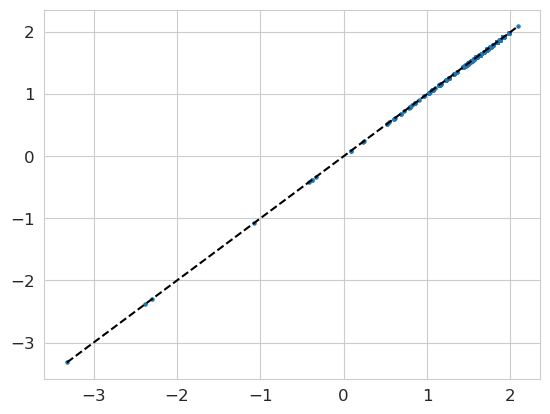

In [40]:
n_forecast = 1000
forecast_idx = np.random.choice(preddesign_N.size, size=n_forecast, replace=False)

class Identity():
    def __init__(self):
        pass
    def predict(self, y):
        return y

identity = Identity()
qcmu_N = utils.get_mean_from_cdf(
    preddesign_N[forecast_idx],
    designsigma_N[forecast_idx],
    identity,
    (0, 60),
    (-60, 0),
    quad_limit=200,
    err_norm='max'
)

plt.scatter(preddesign_N[forecast_idx], qcmu_N, s=5);
plt.plot([np.min(qcmu_N), np.max(qcmu_N)], [np.min(qcmu_N), np.max(qcmu_N)], '--k');

In [ ]:
reload(utils)
reload(gb1)

target_values = np.arange(0.0, 1.51, 0.05)
n_cal = 5000
n_trial = 100
n_design = 1000000
cp_batch_sz = 50000

pp_csv_fname = '../tmp.csv'
cp_csv_fname = '/data/wongfanc/gb1-results/gb1-cp-110724.csv'
design_samples_fname_prefix = 'gb1-h10-5k-030123-samples'

df, cp_df = gb1.run_pp_temperature_selection_experiments(
    model,
    temp2theta, 
    target_values,
    exceedance_threshold=None,
    n_cal=n_cal,
    n_train_lr=0,
    n_design=n_design,
    n_trial=n_trial,
    alpha=0.1,
    cp_batch_sz=cp_batch_sz,
    pp_csv_fname=pp_csv_fname,
    cp_csv_fname=cp_csv_fname,
    design_samples_fname_prefix=design_samples_fname_prefix,
    load_design_samples=True
)

Selection quantity is the mean label.
Range of provided target values: [0.000, 1.500].

Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-5k-030123-samples-t0.2000.npz.
Done getting density ratios for design sequences from temperature 0.2000. (1 s)
Temp 0.2000, trial 0 has CP-based LBs -inf (Bonferroni), 0.3305 (uncorrected) (50 s)
Temp 0.2000, trial 1 has CP-based LBs -inf (Bonferroni), 0.3919 (uncorrected) (99 s)
Temp 0.2000, trial 2 has CP-based LBs -inf (Bonferroni), -0.2214 (uncorrected) (148 s)
Temp 0.2000, trial 3 has CP-based LBs -inf (Bonferroni), -0.0497 (uncorrected) (197 s)
Temp 0.2000, trial 4 has CP-based LBs -inf (Bonferroni), -0.7917 (uncorrected) (246 s)
Temp 0.2000, trial 5 has CP-based LBs -inf (Bonferroni), 0.3305 (uncorrected) (295 s)
Temp 0.2000, trial 6 has CP-based LBs -inf (Bonferroni), -0.9742 (uncorrected) (344 s)
Temp 0.2000, trial 7 has CP-based LBs -inf (Bonferroni), -0.3195 (uncorrected) (393 s)
Temp 0.2000, trial 8 has CP-based LBs 

Temp 0.2000, trial 90 has CP-based LBs -inf (Bonferroni), 0.5545 (uncorrected) (4461 s)
Temp 0.2000, trial 91 has CP-based LBs -inf (Bonferroni), -1.8126 (uncorrected) (4510 s)
Temp 0.2000, trial 92 has CP-based LBs -inf (Bonferroni), -1.5058 (uncorrected) (4559 s)
Temp 0.2000, trial 93 has CP-based LBs -inf (Bonferroni), -1.5085 (uncorrected) (4608 s)
Temp 0.2000, trial 94 has CP-based LBs -inf (Bonferroni), -0.5512 (uncorrected) (4658 s)
Temp 0.2000, trial 95 has CP-based LBs -inf (Bonferroni), 0.0466 (uncorrected) (4707 s)
Temp 0.2000, trial 96 has CP-based LBs -inf (Bonferroni), 1.1902 (uncorrected) (4756 s)
Temp 0.2000, trial 97 has CP-based LBs -inf (Bonferroni), 0.1488 (uncorrected) (4805 s)
Temp 0.2000, trial 98 has CP-based LBs -inf (Bonferroni), -0.1132 (uncorrected) (4854 s)
Temp 0.2000, trial 99 has CP-based LBs -inf (Bonferroni), 0.7288 (uncorrected) (4903 s)
Done with 100 trials for temperature 0.2000 (1 / 101) (4903 s).
Saved PP results to ../tmp.csv.
Saved CP results to

Temp 0.2050, trial 79 has CP-based LBs -inf (Bonferroni), -0.0956 (uncorrected) (8829 s)
Temp 0.2050, trial 80 has CP-based LBs -inf (Bonferroni), -0.3277 (uncorrected) (8878 s)
Temp 0.2050, trial 81 has CP-based LBs -inf (Bonferroni), -1.8585 (uncorrected) (8927 s)
Temp 0.2050, trial 82 has CP-based LBs -inf (Bonferroni), -1.3782 (uncorrected) (8976 s)
Temp 0.2050, trial 83 has CP-based LBs -inf (Bonferroni), -1.8483 (uncorrected) (9025 s)
Temp 0.2050, trial 84 has CP-based LBs -inf (Bonferroni), 0.0700 (uncorrected) (9075 s)
Temp 0.2050, trial 85 has CP-based LBs -inf (Bonferroni), -0.9599 (uncorrected) (9123 s)
Temp 0.2050, trial 86 has CP-based LBs -inf (Bonferroni), -0.5997 (uncorrected) (9172 s)
Temp 0.2050, trial 87 has CP-based LBs -inf (Bonferroni), 0.3436 (uncorrected) (9222 s)
Temp 0.2050, trial 88 has CP-based LBs -inf (Bonferroni), -0.6870 (uncorrected) (9270 s)
Temp 0.2050, trial 89 has CP-based LBs -inf (Bonferroni), -1.7805 (uncorrected) (9319 s)
Temp 0.2050, trial 90 h

Temp 0.2100, trial 67 has CP-based LBs -inf (Bonferroni), -2.8053 (uncorrected) (13141 s)
Temp 0.2100, trial 68 has CP-based LBs -inf (Bonferroni), -1.5514 (uncorrected) (13189 s)
Temp 0.2100, trial 69 has CP-based LBs -inf (Bonferroni), -1.8937 (uncorrected) (13238 s)
Temp 0.2100, trial 70 has CP-based LBs -inf (Bonferroni), -0.4042 (uncorrected) (13287 s)
Temp 0.2100, trial 71 has CP-based LBs -inf (Bonferroni), -1.2167 (uncorrected) (13336 s)
Temp 0.2100, trial 72 has CP-based LBs -inf (Bonferroni), -2.3202 (uncorrected) (13385 s)
Temp 0.2100, trial 73 has CP-based LBs -inf (Bonferroni), -1.8511 (uncorrected) (13434 s)
Temp 0.2100, trial 74 has CP-based LBs -inf (Bonferroni), -0.0065 (uncorrected) (13483 s)
Temp 0.2100, trial 75 has CP-based LBs -inf (Bonferroni), -0.6586 (uncorrected) (13532 s)
Temp 0.2100, trial 76 has CP-based LBs -inf (Bonferroni), -1.3449 (uncorrected) (13580 s)
Temp 0.2100, trial 77 has CP-based LBs -inf (Bonferroni), -2.4081 (uncorrected) (13629 s)
Temp 0.210

In [ ]:
# quantile-calibrated forecasts
# TODO: get integration error low enough
reload(models)
reload(utils)
reload(gb1)

target_values = np.arange(0.0, 1.51, 0.05)
n_cal = 5000
n_trial = 100
n_forecast_designs = 1000
tol = 0.01
quad_limit = 1000

pp_csv_fname = '../tmp.csv'
cp_csv_fname = '/data/wongfanc/gb1-results/gb1-qc-121924.csv'
design_samples_fname_prefix = 'gb1-h10-5k-030123-samples'

df, cp_df = gb1.run_pp_temperature_selection_experiments(
    model,
    temp2theta, 
    target_values,
    exceedance_threshold=None,
    n_cal=n_cal,
    n_train_lr=0,
    n_trial=n_trial,
    n_forecast_designs=n_forecast_designs,
    tol=tol,
    quad_limit=quad_limit,
    pp_csv_fname=pp_csv_fname,
    cp_csv_fname=cp_csv_fname,
    design_samples_fname_prefix=design_samples_fname_prefix,
    load_design_samples=True
)

Selection quantity is the mean label.
Range of provided target values: [0.000, 1.500].

Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-5k-030123-samples-t0.2000.npz.
Done getting density ratios for design sequences from temperature 0.2000. (2 s)
temp 0.2000, trial 4, t1_err 0.0096, t2_err 0.0101
temp 0.2000, trial 7, t1_err 0.0080, t2_err 0.0101
temp 0.2000, trial 18, t1_err 0.0097, t2_err 0.0101
temp 0.2000, trial 20, t1_err 0.0094, t2_err 0.0101
temp 0.2000, trial 22, t1_err 0.0079, t2_err 0.0100
temp 0.2000, trial 24, t1_err 0.0096, t2_err 0.0101
temp 0.2000, trial 29, t1_err 0.0097, t2_err 0.0101
temp 0.2000, trial 31, t1_err 0.0095, t2_err 0.0101
temp 0.2000, trial 33, t1_err 0.0079, t2_err 0.0102
temp 0.2000, trial 34, t1_err 0.0094, t2_err 0.0102
temp 0.2000, trial 49, t1_err 0.0096, t2_err 0.0102
temp 0.2000, trial 50, t1_err 0.0099, t2_err 0.0103
temp 0.2000, trial 53, t1_err 0.0094, t2_err 0.0103
temp 0.2000, trial 56, t1_err 0.0095, t2_err 0.0102
tem

temp 0.2100, trial 98, t1_err 0.0040, t2_err 0.0126
temp 0.2100, trial 99, t1_err 0.0038, t2_err 0.0129
Done with 100 trials for temperature 0.2100 (3 / 101) (7707 s).
Saved PP results to ../tmp.csv.
Saved CP results to /data/wongfanc/gb1-results/gb1-qc-121924.csv (7707 s).

Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-5k-030123-samples-t0.2150.npz.
Done getting density ratios for design sequences from temperature 0.2150. (7709 s)
Done with 100 trials for temperature 0.2150 (4 / 101) (10367 s).
Saved PP results to ../tmp.csv.
Saved CP results to /data/wongfanc/gb1-results/gb1-qc-121924.csv (10367 s).

Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-5k-030123-samples-t0.2200.npz.
Done getting density ratios for design sequences from temperature 0.2200. (10369 s)
temp 0.2200, trial 0, t1_err 0.0108, t2_err 0.0084
temp 0.2200, trial 2, t1_err 0.0109, t2_err 0.0096
temp 0.2200, trial 5, t1_err 0.0109, t2_err 0.0086
temp 0.2200, trial 6, t1

temp 0.2300, trial 61, t1_err 0.0068, t2_err 0.0109
temp 0.2300, trial 62, t1_err 0.0069, t2_err 0.0111
temp 0.2300, trial 63, t1_err 0.0068, t2_err 0.0112
temp 0.2300, trial 64, t1_err 0.0066, t2_err 0.0111
temp 0.2300, trial 65, t1_err 0.0055, t2_err 0.0111
temp 0.2300, trial 66, t1_err 0.0070, t2_err 0.0110
temp 0.2300, trial 67, t1_err 0.0066, t2_err 0.0111
temp 0.2300, trial 68, t1_err 0.0068, t2_err 0.0110
temp 0.2300, trial 69, t1_err 0.0070, t2_err 0.0108
temp 0.2300, trial 70, t1_err 0.0066, t2_err 0.0113
temp 0.2300, trial 71, t1_err 0.0066, t2_err 0.0116
temp 0.2300, trial 72, t1_err 0.0069, t2_err 0.0110
temp 0.2300, trial 73, t1_err 0.0058, t2_err 0.0113
temp 0.2300, trial 74, t1_err 0.0069, t2_err 0.0113
temp 0.2300, trial 75, t1_err 0.0054, t2_err 0.0115
temp 0.2300, trial 76, t1_err 0.0058, t2_err 0.0109
temp 0.2300, trial 77, t1_err 0.0067, t2_err 0.0109
temp 0.2300, trial 78, t1_err 0.0071, t2_err 0.0112
temp 0.2300, trial 79, t1_err 0.0070, t2_err 0.0108
temp 0.2300,

temp 0.2450, trial 25, t1_err 0.0074, t2_err 0.0133
temp 0.2450, trial 26, t1_err 0.0074, t2_err 0.0127
temp 0.2450, trial 27, t1_err 0.0075, t2_err 0.0132
temp 0.2450, trial 28, t1_err 0.0080, t2_err 0.0125
temp 0.2450, trial 29, t1_err 0.0074, t2_err 0.0129
temp 0.2450, trial 30, t1_err 0.0076, t2_err 0.0130
temp 0.2450, trial 31, t1_err 0.0075, t2_err 0.0128
temp 0.2450, trial 32, t1_err 0.0075, t2_err 0.0128
temp 0.2450, trial 33, t1_err 0.0075, t2_err 0.0130
temp 0.2450, trial 34, t1_err 0.0076, t2_err 0.0132
temp 0.2450, trial 35, t1_err 0.0095, t2_err 0.0125
temp 0.2450, trial 36, t1_err 0.0074, t2_err 0.0129
temp 0.2450, trial 37, t1_err 0.0074, t2_err 0.0132
temp 0.2450, trial 38, t1_err 0.0072, t2_err 0.0129
temp 0.2450, trial 39, t1_err 0.0075, t2_err 0.0130
temp 0.2450, trial 40, t1_err 0.0075, t2_err 0.0130
temp 0.2450, trial 41, t1_err 0.0075, t2_err 0.0126
temp 0.2450, trial 42, t1_err 0.0075, t2_err 0.0128
temp 0.2450, trial 43, t1_err 0.0074, t2_err 0.0133
temp 0.2450,